<a href="https://colab.research.google.com/github/mchanwa/COS424/blob/main/Homework2_Fragile_Families_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imputation


In [ ]:
import pandas as pd
import numpy as np

def fillMissing(inputcsv, outputcsv):
    
    # read input csv - takes time
    df = pd.read_csv(inputcsv, low_memory=False)
    # Fix date bug
    df.cf4fint = ((pd.to_datetime(df.cf4fint) - pd.to_datetime('1960-01-01')) / np.timedelta64(1, 'D')).astype(int)
    
    # replace NA's with mode
    df = df.fillna(df.mode().iloc[0])
    # if still NA, replace with 1
    df = df.fillna(value=1)
    # replace negative values with 1
    num = df._get_numeric_data()
    num[num < 0] = 1
    # write filled outputcsv
    df.to_csv(outputcsv, index=False)

In [ ]:
  from os.path import join as pjoin
  data_dir = "drive/MyDrive/FFChallenge_v5"

  ## impute the background data
  in_path = pjoin(data_dir, 'background.csv')
  out_path = pjoin(data_dir, 'background_clean.csv')
  fillMissing(in_path, out_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
background = pd.read_csv(in_path, low_memory=False)

In [ ]:
backgroundClean = pd.read_csv(out_path, low_memory=False)
backgroundClean.head()

,challengeID,cf1intmon,cf1intyr,cf1lenhr,cf1lenmin,cf1twoc,cf1fint,cf1natsm,f1natwt,cf1natsmx,f1natwtx,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a4a,f1a5,f1a5a,f1a6,f1a6a,f1a7,cf1age,f1b1a,f1b1b,f1b2,f1b3,f1b4a,f1b4b,f1b4c,f1b4d,f1b4e,f1b4f,f1b4g,f1b5a,f1b5b,f1b5c,f1b5d,f1b6a,f1b6b,...,q5citywt_rep58,q5citywt_rep59,q5citywt_rep60,q5citywt_rep61,q5citywt_rep62,q5citywt_rep63,q5citywt_rep64,q5citywt_rep65,q5citywt_rep66,q5citywt_rep67,q5citywt_rep68,q5citywt_rep69,q5citywt_rep70,q5citywt_rep71,q5citywt_rep72,m1b7,m1b13,m1b25,f1b7,f1b13,f1b25,m2d6,m2d8,m3d7,m3d9,m3e23,f3d7,f3d9,m4d6,m4d7,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
0,1,1,1,1,1,1,0,1,1,1,1,1,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,8.529998,16.918385,18.157625,9.367338,4.486860,7.617537,20.945231,7.307182,0.949437,3.873586,5.754821,1.442153,7.356769,2.351121,1.235117,6.269946,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
1,2,1,1,0,40,1,1,1,1,1,1,1,68.455658,2,1,1,1,1,1,1,4,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,8.529998,5.701997,7.337275,9.367338,15.415219,7.617537,20.945231,7.307182,0.949437,3.873586,25.380555,1.442153,7.356769,2.351121,1.235117,6.269946,27.680196,2.511131,1.718804,6.473537,16.369411,26.671897,9.628369,15.981275,3.667679
2,3,1,1,0,45,1,1,1,1,1,1,1,42.319057,1,1,1,1,1,1,2,1,102,24,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,8.529998,16.918385,18.279081,9.367338,4.486860,18.553213,20.945231,7.307182,19.144806,3.873586,5.754821,19.800679,7.356769,2.351121,1.235117,6.269946,5.180325,20.867881,24.115867,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
3,4,1,1,0,45,1,1,1,1,1,1,1,25.628830,1,1,1,1,1,1,2,1,101,24,3,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,8.529998,5.988335,7.337275,9.367338,16.084987,7.617537,2.802519,7.307182,19.144806,3.873586,5.754821,19.285963,7.356769,21.220233,23.172680,6.269946,5.180325,22.018875,22.932641,6.473537,1.000000,4.476881,9.628369,1.000000,4.140511
4,5,1,1,1,50,1,1,1,1,1,1,1,41.954487,2,1,1,1,1,1,2,1,1,19,4,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,8.529998,5.988335,7.337275,9.367338,15.293944,7.617537,2.748267,7.307182,19.867851,3.873586,5.754821,20.121984,7.356769,21.386605,23.227584,6.269946,5.180325,22.916602,22.988036,6.473537,1.000000,4.476881,9.628369,1.000000,3.668879


# Training

## Data Preparation

### Without Feature Selection

In [ ]:
#one-hot encoding
#https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def oneHotEncode(df):
  le = LabelEncoder()
  # Categorical boolean mask
  categorical_feature_mask = df.dtypes==object
  # filter categorical columns using mask and turn it into a list
  categorical_cols = df.columns[categorical_feature_mask].tolist()
  if (len(categorical_cols) == 0):
    return

  df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

y = pd.read_csv(pjoin(data_dir, 'train.csv'), low_memory=False)
X = backgroundClean.loc[backgroundClean['challengeID'].isin(y['challengeID'])]

oneHotEncode(X)
oneHotEncode(y)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
data_gpa = (X.loc[X['challengeID'].isin(y[['challengeID', 'gpa']].dropna()['challengeID'])]).drop(columns=['challengeID'])
data_grit = (X.loc[X['challengeID'].isin(y[['challengeID', 'grit']].dropna()['challengeID'])]).drop(columns=['challengeID'])
data_materialHardship = (X.loc[X['challengeID'].isin(y[['challengeID', 'materialHardship']].dropna()['challengeID'])]).drop(columns=['challengeID'])
data_eviction = (X.loc[X['challengeID'].isin(y[['challengeID', 'eviction']].dropna()['challengeID'])]).drop(columns=['challengeID'])
data_layoff = (X.loc[X['challengeID'].isin(y[['challengeID', 'layoff']].dropna()['challengeID'])]).drop(columns=['challengeID'])
data_jobTraining = (X.loc[X['challengeID'].isin(y[['challengeID', 'jobTraining']].dropna()['challengeID'])]).drop(columns=['challengeID'])

In [ ]:
outcomes_gpa = y['gpa'].dropna()
outcomes_grit = y['grit'].dropna()
outcomes_materialHardship = y['materialHardship'].dropna()
outcomes_eviction = y['eviction'].dropna()
outcomes_layoff = y['layoff'].dropna()
outcomes_jobTraining = y['jobTraining'].dropna()

In [ ]:
train_data_gpa, test_data_gpa, train_outcomes_gpa, test_outcomes_gpa = train_test_split(data_gpa, outcomes_gpa, test_size=0.33, random_state=42)
train_data_grit, test_data_grit, train_outcomes_grit, test_outcomes_grit = train_test_split(data_grit, outcomes_grit, test_size=0.33, random_state=42)
train_data_materialHardship, test_data_materialHardship, train_outcomes_materialHardship, test_outcomes_materialHardship = train_test_split(data_materialHardship, outcomes_materialHardship, test_size=0.33, random_state=42)
train_data_eviction, test_data_eviction, train_outcomes_eviction, test_outcomes_eviction = train_test_split(data_eviction, outcomes_eviction, test_size=0.33, random_state=42)
train_data_layoff, test_data_layoff, train_outcomes_layoff, test_outcomes_layoff = train_test_split(data_layoff, outcomes_layoff, test_size=0.33, random_state=42)
train_data_jobTraining, test_data_jobTraining, train_outcomes_jobTraining, test_outcomes_jobTraining = train_test_split(data_jobTraining, outcomes_jobTraining, test_size=0.33, random_state=42)

In [ ]:
all_train_data = backgroundClean.drop(columns=['challengeID'])
oneHotEncode(all_train_data)

### With Feature Selection


In [ ]:
# 'selection percentile' feauture selection

from sklearn.feature_selection import f_regression, SelectPercentile
feature_selection_percentage = 50

gpa_fs = SelectPercentile(f_regression, percentile=feature_selection_percentage)
data_gpa_fs = gpa_fs.fit_transform(data_gpa, outcomes_gpa)

grit_fs = SelectPercentile(f_regression, percentile=feature_selection_percentage)
data_grit_fs = grit_fs.fit_transform(data_grit, outcomes_grit)

materialHardship_fs = SelectPercentile(f_regression, percentile=feature_selection_percentage)
data_materialHardship_fs = materialHardship_fs.fit_transform(data_materialHardship, outcomes_materialHardship)

eviction_fs = SelectPercentile(f_regression, percentile=feature_selection_percentage)
data_eviction_fs = eviction_fs.fit_transform(data_eviction, outcomes_eviction)

layoff_fs = SelectPercentile(f_regression, percentile=feature_selection_percentage)
data_layoff_fs = layoff_fs.fit_transform(data_layoff, outcomes_layoff)

jobTraining_fs = SelectPercentile(f_regression, percentile=feature_selection_percentage)
data_jobTraining_fs = jobTraining_fs.fit_transform(data_jobTraining, outcomes_jobTraining)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: 

In [ ]:
train_data_gpa_fs, test_data_gpa_fs, train_outcomes_gpa_fs, test_outcomes_gpa_fs = train_test_split(data_gpa_fs, outcomes_gpa, test_size=0.33, random_state=42)
train_data_grit_fs, test_data_grit_fs, train_outcomes_grit_fs, test_outcomes_grit_fs = train_test_split(data_grit_fs, outcomes_grit, test_size=0.33, random_state=42)
train_data_materialHardship_fs, test_data_materialHardship_fs, train_outcomes_materialHardship_fs, test_outcomes_materialHardship_fs = train_test_split(data_materialHardship_fs, outcomes_materialHardship, test_size=0.33, random_state=42)
train_data_eviction_fs, test_data_eviction_fs, train_outcomes_eviction_fs, test_outcomes_eviction_fs = train_test_split(data_eviction_fs, outcomes_eviction, test_size=0.33, random_state=42)
train_data_layoff_fs, test_data_layoff_fs, train_outcomes_layoff_fs, test_outcomes_layoff_fs = train_test_split(data_layoff_fs, outcomes_layoff, test_size=0.33, random_state=42)
train_data_jobTraining_fs, test_data_jobTraining_fs, train_outcomes_jobTraining_fs, test_outcomes_jobTraining_fs = train_test_split(data_jobTraining_fs, outcomes_jobTraining, test_size=0.33, random_state=42)

In [ ]:
all_data_gpa_fs = gpa_fs.transform(all_train_data)
all_data_grit_fs = grit_fs.transform(all_train_data)
all_data_materialHardship_fs = materialHardship_fs.transform(all_train_data)
all_data_eviction_fs = eviction_fs.transform(all_train_data)
all_data_layoff_fs = layoff_fs.transform(all_train_data)
all_data_jobTraining_fs = jobTraining_fs.transform(all_train_data)

## Linear Regression & Logistic Regression


In [ ]:
import statistics
import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def stats(outcome, true_y, pred_y, time):
  # print('Coefficients: \n', lr_eviction.)
  # The mean squared error
  print(outcome + ": ")
  print('Mean squared error: %.2f'
        % mean_squared_error(true_y, pred_y))
  # The coefficient of determination: 1 is perfect prediction
  print('Coefficient of determination: %.2f'
        % r2_score(true_y, pred_y))
  print('Time to fit and predict: ', time)
  print()

In [ ]:
# Linear Regression - without regularization

# gpa
start = time.time()
lr_gpa = make_pipeline(StandardScaler(), LinearRegression()).fit(train_data_gpa, train_outcomes_gpa)
lr_prediction_gpa = lr_gpa.predict(test_data_gpa)
prediction_gpa_all = lr_gpa.predict(all_train_data)
end = time.time()
stats('gpa', test_outcomes_gpa, lr_prediction_gpa, end-start)

# grit
start = time.time()
lr_grit = make_pipeline(StandardScaler(), LinearRegression()).fit(train_data_grit, train_outcomes_grit)
lr_prediction_grit = lr_grit.predict(test_data_grit)
prediction_grit_all = lr_grit.predict(all_train_data)
end = time.time()
stats('grit', test_outcomes_grit, lr_prediction_grit, end-start)

# materialHardship
start = time.time()
lr_materialHardship = make_pipeline(StandardScaler(), LinearRegression()).fit(train_data_materialHardship, train_outcomes_materialHardship)
lr_prediction_materialHardship = lr_materialHardship.predict(test_data_materialHardship)
prediction_materialHardship_all = lr_materialHardship.predict(all_train_data)
end = time.time()
stats('materialHardship', test_outcomes_materialHardship, lr_prediction_materialHardship, end-start)

gpa: 
Mean squared error: 0.72
Coefficient of determination: -0.69
Time to fit and predict:  4.80043363571167

grit: 
Mean squared error: 0.38
Coefficient of determination: -0.52
Time to fit and predict:  6.069481134414673

materialHardship: 
Mean squared error: 0.03
Coefficient of determination: -0.25
Time to fit and predict:  6.260276794433594



In [ ]:
# Linear Regression - with Lasso regularization

# gpa
start = time.time()
lr_gpa = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=0.02)).fit(train_data_gpa, train_outcomes_gpa)
lr_prediction_gpa = lr_gpa.predict(test_data_gpa)
prediction_gpa_all = lr_gpa.predict(all_train_data)
end = time.time()
stats('gpa', test_outcomes_gpa, lr_prediction_gpa, end-start)

# grit
start = time.time()
lr_grit = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=0.03)).fit(train_data_grit, train_outcomes_grit)
lr_prediction_grit = lr_grit.predict(test_data_grit)
prediction_grit_all = lr_grit.predict(all_train_data)
end = time.time()
stats('grit', test_outcomes_grit, lr_prediction_grit, end-start)

# materialHardship
start = time.time()
lr_materialHardship = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=0.04)).fit(train_data_materialHardship, train_outcomes_materialHardship)
lr_prediction_materialHardship = lr_materialHardship.predict(test_data_materialHardship)
prediction_materialHardship_all = lr_materialHardship.predict(all_train_data)
end = time.time()
stats('materialHardship', test_outcomes_materialHardship, lr_prediction_materialHardship, end-start)

gpa: 
Mean squared error: 0.42
Coefficient of determination: 0.02
Time to fit and predict:  5.140465974807739

grit: 
Mean squared error: 0.25
Coefficient of determination: 0.01
Time to fit and predict:  1.7099504470825195

materialHardship: 
Mean squared error: 0.02
Coefficient of determination: 0.02
Time to fit and predict:  1.2375309467315674



In [ ]:
# Linear Regression - with Ridge (l2) regularization

# gpa
start = time.time()
lr_gpa = make_pipeline(StandardScaler(), linear_model.Ridge(alpha=0.1)).fit(train_data_gpa, train_outcomes_gpa)
lr_prediction_gpa = lr_gpa.predict(test_data_gpa)
prediction_gpa_all = lr_gpa.predict(all_train_data)
end = time.time()
stats('gpa', test_outcomes_gpa, lr_prediction_gpa, end-start)

# grit
start = time.time()
lr_grit = make_pipeline(StandardScaler(), linear_model.Ridge(alpha=0.1)).fit(train_data_grit, train_outcomes_grit)
lr_prediction_grit = lr_grit.predict(test_data_grit)
prediction_grit_all = lr_grit.predict(all_train_data)
end = time.time()
stats('grit', test_outcomes_grit, lr_prediction_grit, end-start)

# materialHardship
start = time.time()
lr_materialHardship = make_pipeline(StandardScaler(), linear_model.Ridge(alpha=0.1)).fit(train_data_materialHardship, train_outcomes_materialHardship)
lr_prediction_materialHardship = lr_materialHardship.predict(test_data_materialHardship)
prediction_materialHardship_all = lr_materialHardship.predict(all_train_data)
end = time.time()
stats('materialHardship', test_outcomes_materialHardship, lr_prediction_materialHardship, end-start)

gpa: 
Mean squared error: 0.72
Coefficient of determination: -0.67
Time to fit and predict:  1.3396031856536865

grit: 
Mean squared error: 0.38
Coefficient of determination: -0.52
Time to fit and predict:  1.5349390506744385

materialHardship: 
Mean squared error: 0.03
Coefficient of determination: -0.25
Time to fit and predict:  1.5779428482055664



In [ ]:
# Logistic regression - binary data

# eviction
start = time.time()
lr_eviction = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)).fit(train_data_eviction, train_outcomes_eviction)
lr_prediction_eviction = lr_eviction.predict(test_data_eviction)
prediction_eviction_all = lr_eviction.predict(all_train_data)
end = time.time()
print("eviction: ")
print("score = {0}".format(lr_eviction.score(test_data_eviction, test_outcomes_eviction)))
print("fit and predict time (Logistic Regression, eviction): " + str(end-start))
print()

# layoff
start = time.time()
lr_layoff = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)).fit(train_data_layoff, train_outcomes_layoff)
lr_prediction_layoff = lr_layoff.predict(test_data_layoff)
prediction_layoff_all = lr_layoff.predict(all_train_data)
end = time.time()
print("layoff: ")
print("score = {0}".format(lr_layoff.score(test_data_layoff, test_outcomes_layoff)))
print("fit and predict time (Logistic Regression, layoff): " + str(end-start))
print()

# jobTraining
start = time.time()
lr_jobTraining = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)).fit(train_data_jobTraining, train_outcomes_jobTraining)
lr_jobTraining_layoff = lr_jobTraining.predict(test_data_jobTraining)
prediction_jobTraining_all = lr_jobTraining.predict(all_train_data)
end = time.time()
print("jobTraining: ")
print("fit and predict time (Logistic Regression, jobTraining): " + str(end-start))
print("score = {0}".format(lr_jobTraining.score(test_data_jobTraining, test_outcomes_jobTraining)))
print()

eviction: 
score = 0.9398340248962656
fit and predict time (Logistic Regression, eviction): 5.5950608253479

layoff: 
score = 0.7630331753554502
fit and predict time (Logistic Regression, layoff): 4.628309726715088

jobTraining: 
fit and predict time (Logistic Regression, jobTraining): 5.4961183071136475
score = 0.6977225672877847



In [ ]:
# Logistic regression with Feature Selection - binary data

# eviction
start = time.time()
lr_eviction = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)).fit(train_data_eviction_fs, train_outcomes_eviction_fs)
lr_prediction_eviction = lr_eviction.predict(test_data_eviction_fs)
prediction_eviction_all = lr_eviction.predict(all_data_eviction_fs)
end = time.time()
print("eviction: ")
print("score = {0}".format(lr_eviction.score(test_data_eviction_fs, test_outcomes_eviction_fs)))
print("fit and predict time (Logistic Regression, eviction): " + str(end-start))
print()

# layoff
start = time.time()
lr_layoff = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)).fit(train_data_layoff_fs, train_outcomes_layoff_fs)
lr_prediction_layoff = lr_layoff.predict(test_data_layoff_fs)
prediction_layoff_all = lr_layoff.predict(all_data_layoff_fs)
end = time.time()
print("layoff: ")
print("score = {0}".format(lr_layoff.score(test_data_layoff_fs, test_outcomes_layoff_fs)))
print("fit and predict time (Logistic Regression, layoff): " + str(end-start))
print()

# jobTraining
start = time.time()
lr_jobTraining = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)).fit(train_data_jobTraining_fs, train_outcomes_jobTraining_fs)
lr_prediction_jobTraining = lr_jobTraining.predict(test_data_jobTraining_fs)
prediction_jobTraining_all = lr_jobTraining.predict(all_data_jobTraining_fs)
end = time.time()
print("jobTraining: ")
print("fit and predict time (Logistic Regression, jobTraining): " + str(end-start))
print("score = {0}".format(lr_jobTraining.score(test_data_jobTraining_fs, test_outcomes_jobTraining_fs)))
print()

eviction: 
score = 0.9336099585062241
fit and predict time (Logistic Regression, eviction): 0.23079395294189453

layoff: 
score = 0.7819905213270142
fit and predict time (Logistic Regression, layoff): 0.31537342071533203

jobTraining: 
fit and predict time (Logistic Regression, jobTraining): 0.3763298988342285
score = 0.7805383022774327



In [ ]:
import matplotlib.pyplot as plt

def draw_scatter_plot(column, true_y, pred_y):
  train_outcomes = pd.read_csv(pjoin(data_dir, 'train.csv'), low_memory=False)
  oneHotEncode(train_outcomes)
  rows_without_nan = [index for index, row in pd.DataFrame(train_outcomes[column]).iterrows() if not row.isnull().any()]
  
  plt.scatter(true_y, pred_y[rows_without_nan])
  plt.title(column)
  plt.xlabel('true_y')
  plt.ylabel('pred_y')
  plt.show()

[3, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 25, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 44, 47, 51, 55, 56, 58, 59, 60, 63, 64, 65, 68, 70, 71, 72, 73, 79, 80, 81, 85, 89, 90, 91, 93, 94, 95, 96, 98, 99, 100, 101, 104, 108, 110, 114, 116, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 130, 133, 134, 137, 141, 142, 143, 144, 153, 154, 155, 156, 159, 160, 162, 163, 165, 166, 168, 169, 171, 172, 173, 175, 177, 179, 181, 185, 187, 189, 192, 193, 194, 195, 196, 197, 200, 201, 205, 206, 210, 212, 213, 216, 218, 219, 220, 223, 224, 225, 227, 229, 230, 231, 232, 234, 235, 247, 252, 253, 255, 256, 257, 258, 261, 262, 265, 269, 270, 272, 273, 278, 283, 285, 287, 289, 291, 292, 294, 295, 296, 297, 298, 299, 303, 304, 305, 306, 307, 308, 309, 310, 311, 314, 319, 320, 321, 322, 323, 325, 326, 328, 329, 333, 334, 336, 337, 339, 344, 345, 346, 351, 352, 353, 354, 355, 357, 358, 361, 362, 363, 368, 369, 370, 372, 373, 376, 379, 380, 381, 382, 384, 385, 387, 389, 390, 391, 392, 39

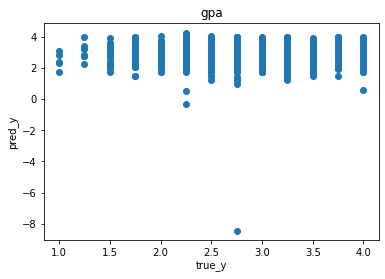

In [ ]:
draw_scatter_plot('gpa', train_outcomes_gpa, lr_prediction_gpa)

In [ ]:
def cross_validation(classifier, numfolds):
  cv_results_accuracy = \
    cross_validate(classifier, train_vocab_df, train_labels_arr, cv=numfolds, scoring='accuracy')
  cv_results_recall = \
    cross_validate(classifier, train_vocab_df, train_labels_arr, cv=numfolds, scoring='recall')
  cv_results_f1 = \
    cross_validate(classifier, train_vocab_df, train_labels_arr, cv=numfolds, scoring='f1')
  cv_results_precision = \
    cross_validate(classifier, train_vocab_df, train_labels_arr, cv=numfolds, scoring='precision')

  print("accuracy cv: ", statistics.mean(cv_results_accuracy['test_score']))
  print("precision cv: ", statistics.mean(cv_results_precision['test_score']))
  print("recall cv: ", statistics.mean(cv_results_recall['test_score']))
  print("f1 cv: ", statistics.mean(cv_results_f1['test_score']))

{'fit_time': array([3.38650465, 3.20733905, 2.96887326, 3.53054237, 3.53649545]), 'score_time': array([0.11787295, 0.08345985, 0.09973311, 0.07309055, 0.10323691]), 'test_score': array([0.93835616, 0.94520548, 0.93835616, 0.93493151, 0.93127148])}


## KNN

In [ ]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

# eviction
start = time.time()
knn_eviction = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)).fit(train_data_eviction, train_outcomes_eviction)
lr_prediction_eviction = knn_eviction.predict(test_data_eviction)
prediction_eviction_all = knn_eviction.predict(all_train_data)
end = time.time()
print("eviction: ")
print("score = {0}".format(knn_eviction.score(test_data_eviction, test_outcomes_eviction)))
print("fit and predict time (KNN, eviction): " + str(end-start))
print()

# layoff
start = time.time()
knn_layoff = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)).fit(train_data_layoff, train_outcomes_layoff)
lr_prediction_layoff = knn_layoff.predict(test_data_layoff)
prediction_layoff_all = knn_layoff.predict(all_train_data)
end = time.time()
print("layoff: ")
print("score = {0}".format(knn_layoff.score(test_data_layoff, test_outcomes_layoff)))
print("fit and predict time (KNN, layoff): " + str(end-start))
print()

# jobTraining
start = time.time()
knn_jobTraining = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)).fit(train_data_jobTraining, train_outcomes_jobTraining)
lr_prediction_jobTraining = knn_jobTraining.predict(test_data_jobTraining)
prediction_jobTraining_all = knn_jobTraining.predict(all_train_data)
end = time.time()
print("jobTraining: ")
print("score = {0}".format(knn_jobTraining.score(test_data_jobTraining, test_outcomes_jobTraining)))
print("fit and predict time (KNN, jobTraining): " + str(end-start))
print()

eviction: 
score = 0.9439834024896265
fit and predict time (KNN, eviction): 154.13661551475525

layoff: 
score = 0.7748815165876777
fit and predict time (KNN, layoff): 110.80797290802002

jobTraining: 
score = 0.7370600414078675
fit and predict time (KNN, jobTraining): 149.17587900161743



In [ ]:
# KNN - with feature selection

from sklearn.neighbors import KNeighborsClassifier

# eviction
start = time.time()
knn_eviction = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)).fit(train_data_eviction_fs, train_outcomes_eviction_fs)
lr_prediction_eviction = knn_eviction.predict(test_data_eviction_fs)
prediction_eviction_all = knn_eviction.predict(all_data_eviction_fs)
end = time.time()
print("eviction: ")
print("score = {0}".format(knn_eviction.score(test_data_eviction_fs, test_outcomes_eviction_fs)))
print("fit and predict time (KNN, eviction): " + str(end-start))
print()

# layoff
start = time.time()
knn_layoff = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)).fit(train_data_layoff_fs, train_outcomes_layoff_fs)
lr_prediction_layoff = knn_layoff.predict(test_data_layoff_fs)
prediction_layoff_all = knn_layoff.predict(all_data_layoff_fs)
end = time.time()
print("layoff: ")
print("score = {0}".format(knn_layoff.score(test_data_layoff_fs, test_outcomes_layoff_fs)))
print("fit and predict time (KNN, layoff): " + str(end-start))
print()

# jobTraining
start = time.time()
knn_jobTraining = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)).fit(train_data_jobTraining_fs, train_outcomes_jobTraining_fs)
lr_prediction_jobTraining = knn_jobTraining.predict(test_data_jobTraining_fs)
prediction_jobTraining_all = knn_jobTraining.predict(all_data_jobTraining_fs)
end = time.time()
print("jobTraining: ")
print("score = {0}".format(knn_jobTraining.score(test_data_jobTraining_fs, test_outcomes_jobTraining_fs)))
print("fit and predict time (KNN, jobTraining): " + str(end-start))
print()

eviction: 
score = 0.9439834024896265
fit and predict time (KNN, eviction): 74.4458954334259

layoff: 
score = 0.7772511848341233
fit and predict time (KNN, layoff): 56.19696116447449

jobTraining: 
score = 0.722567287784679
fit and predict time (KNN, jobTraining): 75.23535299301147



In [ ]:
challengeIDs = backgroundClean['challengeID']
predicted_outcomes = np.stack((challengeIDs,
                               prediction_gpa_all,
                               prediction_grit_all,
                               prediction_materialHardship_all,
                               prediction_eviction_all,
                               prediction_layoff_all,
                               prediction_jobTraining_all))
predicted_outcomes = predicted_outcomes.T
headers = ['challengeID','gpa','grit','materialHardship', 'eviction', 'layoff', 'jobTraining']
pd.DataFrame(predicted_outcomes).to_csv(pjoin(data_dir, 'prediction.csv'), header=headers, index=False)